## Описание задачи

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

 Целью проекта будет модель предсказания стоимости автомобиля на вторичном рынке.
 
## Description of the task
Many people know about marketplaces where used items are sold, where you can inexpensively buy a high-quality and useful item. But the question always concerns us: who sets the price and how, and what characteristics most influence the final sale price?! The question becomes especially relevant when it comes to expensive goods, such as cars!

The goal of the project will be a model for predicting the cost of a car on the secondary market.

https://www.kaggle.com/competitions/used-cars-price-prediction-22ds
    
соревнование здесь

competition here


In [1]:
#монтирование диска
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


## 0. Бибилиотеки
## 0. Libraries

In [2]:
!pip3 install vininfo pyvin -q
!pip install vin-decoder-nhtsa -q

In [3]:
import pandas as pd
import numpy as np
import os
#from ydata_profiling import ProfileReport
from vininfo import Vin
from pyvin import VIN
from vin_decoder_nhtsa.decoder import Vin

from tqdm import notebook
from tqdm.notebook import tqdm
tqdm.pandas()

#import polars

from scipy.stats import mode
from scipy.sparse import csr_matrix

from scipy.sparse import hstack

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
#from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler

from sklearn.metrics import mean_absolute_percentage_error


In [1]:
#константы constants
STATE = 33443

#Путь к каталогу с данными
#Path to the data directory
DATA_PATH = '/content/drive/MyDrive/Peton/mastersk_yandex/'

## 1. Исследовательский анализ данных

In [5]:
#прочитаем данные train
#read train
patch = os.path.join(DATA_PATH, 'train.csv')
train = pd.read_csv(patch)
train.sample(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
317819,2011,Chevrolet,Silverado 1500,LS,Crew Cab,automatic,3gcpcrea9bg157780,nv,2.6,72549.0,—,black,henderson chevrolet company,17900,Thu Mar 05 2015 03:45:00 GMT-0800 (PST)
355249,2010,Chevrolet,Camaro,2SS,Coupe,manual,2g1ft1ew9a9142030,ca,2.8,61700.0,black,black,remarketing by ge/xpress rent a car,20500,Tue Jan 13 2015 12:00:00 GMT-0800 (PST)
314257,2013,Dodge,Grand Caravan,SXT,Minivan,automatic,2c4rdgcg5dr719317,nc,2.6,65000.0,blue,black,dtg operations inc,10800,Tue Jun 16 2015 02:15:00 GMT-0700 (PDT)


In [6]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 325.9 MB


In [7]:
#проверка дубликатов строк
#checking for duplicate rows
train.duplicated().sum()

0

In [8]:
#просмотр пропущенных значений
#view missing values
train.isna().sum()

year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

In [9]:
#view missing values for non-empty column 'make'
train.loc[~train.make.isna()].isna().sum()

year                0
make                0
model              80
trim              294
body             2350
transmission    50075
vin                 0
state               0
condition        9339
odometer           67
color             572
interior          572
seller              0
sellingprice        0
saledate            0
dtype: int64

То есть большинство пропусков одновременно в нескольких столбцах

That is, most of the gaps are in several columns at the same time

In [10]:
#прочитаем данные test
#read test data
patch = os.path.join(DATA_PATH, 'test.csv')
test = pd.read_csv(patch)
test.sample(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
97970,2012,Toyota,RAV4,Base,suv,automatic,2t3bf4dv1cw207856,nj,3.4,24707.0,brown,beige,hudson toyota,Wed Jun 03 2015 02:30:00 GMT-0700 (PDT)
33465,2011,Honda,Odyssey,EX-L,Minivan,automatic,5fnrl5h66bb093681,pa,3.5,34459.0,black,gray,"ahfc/honda lease trust/hvt, inc.",Fri Feb 06 2015 01:00:00 GMT-0800 (PST)
69969,2014,Nissan,Altima,2.5,Sedan,automatic,1n4al3ap2ec186564,ca,3.7,16557.0,white,black,nissan motor acceptance corporation,Wed Feb 11 2015 04:30:00 GMT-0800 (PST)


In [11]:
#проверка дубликатов строк
#checking for duplicate rows test
test.duplicated().sum()

0

In [12]:
#просмотр пропущенных значений
#view missing values test data
test.isna().sum()

year                0
make             2061
model            2079
trim             2114
body             2594
transmission    13011
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
dtype: int64

In [13]:
test.loc[(~test.make.isna())&(~test.model.isna())].isna().sum()

year                0
make                0
model               0
trim               53
body              533
transmission    12655
vin                 0
state               0
condition        2358
odometer           18
color             157
interior          157
seller              0
saledate            0
dtype: int64

Подобная картина с пропусками и в датасете тест

A similar picture with gaps in the test dataset

In [246]:
#проверка работы вин декодера
#check vin decoder
v_i_n = 'KNDJH741685009910'.upper()

In [15]:
vehicle = VIN(v_i_n)

DEBUG:root:%s check [OK]
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): vpic.nhtsa.dot.gov:443
DEBUG:urllib3.connectionpool:https://vpic.nhtsa.dot.gov:443 "POST /api/vehicles/DecodeVINValuesBatch/ HTTP/1.1" 200 2014


In [16]:
(vehicle.Make,
 vehicle.Model,
 vehicle.ModelYear,
 vehicle.Series,
 vehicle.Doors,
 vehicle.EngineHP,
 vehicle.AirBagLocFront,
 vehicle.BodyClass,
 vehicle.FuelTypePrimary,
 #vehicle.OtherEngineInfo,
 vehicle.VehicleType,
 vehicle.DisplacementCC,
 vehicle.EngineCylinders,
 #vehicle.SeatBeltsAll
)

('',
 '',
 '2008',
 '',
 '4',
 '',
 '',
 'Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)',
 '',
 'MULTIPURPOSE PASSENGER VEHICLE (MPV)',
 '',
 '')

In [17]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 80.6 MB


In [18]:
#прочитаем данные sample_submission
#read sample_submission data
patch = os.path.join(DATA_PATH, 'sample_submission.csv')
sample_submission = pd.read_csv(patch)
sample_submission.sample(5)

,vin,sellingprice
78180,2g1wc5e35d1183190,13592.209588
21130,kmhfh4jg1ea342642,13592.209588
50551,1n4aa5ap5cc800103,13592.209588
105823,2c3ka53v89h634633,13592.209588
18814,4t1bf1fkxeu862918,13592.209588


In [19]:
sample_submission.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           110058 non-null  object 
 1   sellingprice  110058 non-null  float64
dtypes: float64(1), object(1)
memory usage: 8.6 MB


In [20]:
sample_submission['sellingprice'].unique()

array([13592.20958758])

Табличка `sample_submission` содержить только вин номера и столбец с одной ценой.

Для нас она не нужна, так как не содержит полезной информации.

The `sample_submission` table contains only VIN numbers and a column with one price.

It is not needed for us, since it does not contain useful information.

### 1.1. Исследование train

In [23]:
train['seller'].unique().shape

(13025,)

In [24]:
train['vin'].unique().shape

(440236,)

Все номера вин в трейн датасете уникальные.

Это значит что часть признаков можно выбросить и заново заполнить некоторые столбцы таблицы.

Например: make, model, body
-- --
All VIN numbers in the train dataset are unique.

This means that some of the features can be discarded and some columns of the table can be refilled.

For example: make, model, body

In [25]:
test['vin'].unique().shape

(110058,)

Vin в тесте также уникальные

Vin in the test is also unique

## 2 Заполнение пропущеных значений
## 2 Filling in missing values

In [27]:
#функция для получения из вин номера разных признаков
#function for obtaining numbers of different characteristics from VINs
from vin_decoder_nhtsa.decoder import Vin

def new_futures(vin):

    vin = vin.upper()
    vehicle = Vin(vin)

    Make = vehicle.Make
    Model = vehicle.Model
    ModelYear = vehicle.ModelYear
    Series = vehicle.Series
    Doors = vehicle.Doors
    EngineHP = vehicle.EngineHP
    AirBagLocFront = vehicle.AirBagLocFront
    BodyClass = vehicle.BodyClass
    FuelTypePrimary = vehicle.FuelTypePrimary
    VehicleType = vehicle.VehicleType
    DisplacementCC = vehicle.DisplacementCC
    EngineCylinders = vehicle.EngineCylinders

    return pd.Series([Make,
                      Model,
                      ModelYear,
                      Series,
                      Doors,
                      EngineHP,
                      AirBagLocFront,
                      BodyClass,
                      FuelTypePrimary,
                      VehicleType,
                      DisplacementCC,
                      EngineCylinders
                     ])

In [28]:
#пока не воспользовался
#not use it
'''
train[['Make',
       'Model',
       'ModelYear',
       'Series',
       'Doors',
       'EngineHP',
       'AirBagLocFront',
       'BodyClass',
       'FuelTypePrimary',
       'VehicleType',
       'DisplacementCC',
       'EngineCylinders'
      ]] = train['vin'].progress_apply(new_futures)
      '''

"\ntrain[['Make',\n       'Model',\n       'ModelYear',\n       'Series',\n       'Doors',\n       'EngineHP',\n       'AirBagLocFront',\n       'BodyClass',\n       'FuelTypePrimary',\n       'VehicleType',\n       'DisplacementCC',\n       'EngineCylinders'\n      ]] = train['vin'].progress_apply(new_futures)\n      "

In [29]:
#функция для получения из вин номера - производителя авто и модели авто
#function for obtaining from VIN numbers - car manufacturer (make) and car model
def from_vin(row):
    if (pd.isna(row['make'])) or (pd.isna(row['model'])):
        vin = row['vin'].upper()
        vehicle = Vin(vin)
        Make = vehicle.Make
        Model = vehicle.Model
        return pd.Series([Make, Model])
    else:
        return pd.Series([row['make'], row['model']])

In [30]:
#заполнение пропусков в 'make', 'model'
#filling in 'make', 'model'

#train[['make', 'model']] = train.progress_apply(from_vin, axis=1)

In [31]:
#заполнение пропусков в 'make', 'model'
#filling in 'make', 'model'

#test[['make', 'model']] = test.progress_apply(from_vin, axis=1)

In [32]:
#train.loc[train['make'].isna()]

In [33]:
#сохранение результатов на диск. С целью дальнейшей загрузки, потому что прогон идет более часа.
#saving results to disk. For the purpose of further loading, because the run takes more than an hour.

#patch = os.path.join(DATA_PATH, 'train_fill.csv')
#pd.DataFrame(train).to_csv(patch, index=False)

In [34]:
#сохранение результатов на диск Test. С целью дальнейшей загрузки.

#patch = os.path.join(DATA_PATH, 'test_fill.csv')
#pd.DataFrame(test).to_csv(patch, index=False)

In [35]:
#прочитаем записанные данные с диска train_fill
#read the recorded data from the disk train_fill

patch = os.path.join(DATA_PATH, 'train_fill.csv')
train_fill = pd.read_csv(patch)
train_fill.sample(2)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
387680,2008,Toyota,Yaris,Base,sedan,automatic,jtdbt923281297077,nv,NaN,110792.0,black,—,desert trail auto,5000,Thu Dec 18 2014 11:45:00 GMT-0800 (PST)
291609,2014,Ford,Fusion,SE,sedan,automatic,3fa6p0hd1er160091,fl,3.8,32206.0,—,black,ars/avis budget group,14500,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)


In [36]:
#прочитаем записанные данные с диска test_fill
#read the recorded data from the disk test_fill

patch = os.path.join(DATA_PATH, 'test_fill.csv')
test_fill = pd.read_csv(patch)
test_fill.sample(2)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
27146,2011,Ford,Fusion Hybrid,Base,Sedan,automatic,3fadp0l34br305531,ca,3.4,56369.0,gray,black,ge fleet services for itself/servicer,Thu Jan 22 2015 04:00:00 GMT-0800 (PST)
102887,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0hd4er143866,tx,3.3,37607.0,white,black,avis corporation,Wed Feb 25 2015 02:15:00 GMT-0800 (PST)


In [37]:
#checking filling values
test_fill.isna().sum()

year                0
make                0
model               0
trim             2114
body             2594
transmission    13011
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
dtype: int64

In [40]:
#additional check
test_fill.loc[(test_fill['make'].isna())|(test_fill['model'].isna())]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate


In [42]:
#удаление строк с неизвестными производителями и марками авто
#removing rows with unknown 'make' and 'model'
train_fill = train_fill.loc[(~train['make'].isna())&(~train['model'].isna())].reset_index(drop=True)

In [43]:
#категориальные столбцы
#categorical columns
cat_col = [##'year',
           'make',
           'model',
           'trim',
           'body',
           'transmission',
           ##'vin',
           ##'state',
           ##'condition',
           ##'odometer',
           'color',
           'interior',
           'seller',
           ##'sellingprice',
           ##'saledate'
           ]

In [44]:
#перевод всех значений кат столбцов в нижний регистр,удаление первого и последнего пробела
#convert all cat column values to lower case, removing the first and last space

for j in cat_col:
    train_fill[j] = train_fill[j].str.lower().str.strip()

In [45]:
#перевод всех значений кат столбцов в нижний регистр,удаление первого и последнего пробела
#also for test

for j in cat_col:
    test_fill[j] = test_fill[j].str.lower().str.strip()

In [46]:
#check unique values
sorted(train_fill.make.unique())

['acura',
 'airstream',
 'aston martin',
 'audi',
 'bentley',
 'bmw',
 'buick',
 'cadillac',
 'chevrolet',
 'chrysler',
 'daewoo',
 'dodge',
 'dodge tk',
 'dot',
 'ferrari',
 'fiat',
 'fisker',
 'ford',
 'ford truck',
 'geo',
 'gmc',
 'gmc truck',
 'honda',
 'hummer',
 'hyundai',
 'infiniti',
 'isuzu',
 'jaguar',
 'jeep',
 'kia',
 'lamborghini',
 'land rover',
 'landrover',
 'lexus',
 'lincoln',
 'maserati',
 'mazda',
 'mazda tk',
 'mercedes',
 'mercedes-b',
 'mercedes-benz',
 'mercury',
 'mini',
 'mitsubishi',
 'nissan',
 'oldsmobile',
 'plymouth',
 'pontiac',
 'porsche',
 'ram',
 'rolls-royce',
 'saab',
 'saturn',
 'scion',
 'smart',
 'subaru',
 'suzuki',
 'tesla',
 'toyota',
 'volkswagen',
 'volvo',
 'vw']

In [47]:
#also for test
sorted(test_fill.make.unique())

['acura',
 'aston martin',
 'audi',
 'bentley',
 'bmw',
 'buick',
 'cadillac',
 'chev truck',
 'chevrolet',
 'chrysler',
 'daewoo',
 'dodge',
 'ferrari',
 'fiat',
 'fisker',
 'ford',
 'ford tk',
 'freightliner',
 'geo',
 'gmc',
 'honda',
 'hummer',
 'hyundai',
 'hyundai tk',
 'infiniti',
 'isuzu',
 'jaguar',
 'jeep',
 'kia',
 'land rover',
 'landrover',
 'lexus',
 'lincoln',
 'lotus',
 'maserati',
 'mazda',
 'mercedes',
 'mercedes-benz',
 'mercury',
 'mini',
 'mitsubishi',
 'nissan',
 'oldsmobile',
 'plymouth',
 'pontiac',
 'porsche',
 'ram',
 'rolls-royce',
 'saab',
 'saturn',
 'scion',
 'smart',
 'subaru',
 'suzuki',
 'tesla',
 'toyota',
 'volkswagen',
 'volvo',
 'vw']

In [48]:
#приведение названий производителей к одному виду
#функция для замены

#bringing the names of manufacturers to the same type

def change_val(value):
    if value=='dodge tk':
        return 'dodge'
    elif value=='ford truck':
        return 'ford'
    elif value=='gmc truck':
        return 'gmc'

    elif value=='chev truck':
        return 'chevrolet'
    elif value=='ford tk':
        return 'ford'
    elif value=='hyundai tk':
        return 'hyundai'


    elif value=='land rover':
        return 'landrover'
    elif value=='mazda tk':
        return 'mazda'
    elif value=='mercedes-benz' or value=='mercedes-b':
        return 'mercedes'
    elif value=='vw':
        return 'volkswagen'
    elif value=='land rover':
        return 'landrover'
    else:
        return value

In [49]:
#замена названий производителей авто
#replacing car manufacturer names

train_fill.make = train_fill.make.apply(change_val)

In [50]:
sorted(train_fill.make.unique())

['acura',
 'airstream',
 'aston martin',
 'audi',
 'bentley',
 'bmw',
 'buick',
 'cadillac',
 'chevrolet',
 'chrysler',
 'daewoo',
 'dodge',
 'dot',
 'ferrari',
 'fiat',
 'fisker',
 'ford',
 'geo',
 'gmc',
 'honda',
 'hummer',
 'hyundai',
 'infiniti',
 'isuzu',
 'jaguar',
 'jeep',
 'kia',
 'lamborghini',
 'landrover',
 'lexus',
 'lincoln',
 'maserati',
 'mazda',
 'mercedes',
 'mercury',
 'mini',
 'mitsubishi',
 'nissan',
 'oldsmobile',
 'plymouth',
 'pontiac',
 'porsche',
 'ram',
 'rolls-royce',
 'saab',
 'saturn',
 'scion',
 'smart',
 'subaru',
 'suzuki',
 'tesla',
 'toyota',
 'volkswagen',
 'volvo']

In [51]:
#замена названий производителей авто
#also for test

test_fill.make = test_fill.make.apply(change_val)

In [52]:
sorted(test_fill.make.unique())

['acura',
 'aston martin',
 'audi',
 'bentley',
 'bmw',
 'buick',
 'cadillac',
 'chevrolet',
 'chrysler',
 'daewoo',
 'dodge',
 'ferrari',
 'fiat',
 'fisker',
 'ford',
 'freightliner',
 'geo',
 'gmc',
 'honda',
 'hummer',
 'hyundai',
 'infiniti',
 'isuzu',
 'jaguar',
 'jeep',
 'kia',
 'landrover',
 'lexus',
 'lincoln',
 'lotus',
 'maserati',
 'mazda',
 'mercedes',
 'mercury',
 'mini',
 'mitsubishi',
 'nissan',
 'oldsmobile',
 'plymouth',
 'pontiac',
 'porsche',
 'ram',
 'rolls-royce',
 'saab',
 'saturn',
 'scion',
 'smart',
 'subaru',
 'suzuki',
 'tesla',
 'toyota',
 'volkswagen',
 'volvo']

In [53]:
#ckech filling values
train_fill.isna().sum()

year                0
make                0
model               0
trim              294
body             2350
transmission    50071
vin                 0
state               0
condition        9339
odometer           67
color             567
interior          567
seller              0
sellingprice        0
saledate            0
dtype: int64

In [54]:
#for test
test_fill.isna().sum()

year                0
make                0
model               0
trim             2114
body             2594
transmission    13011
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
dtype: int64

In [55]:
#группировка о производителю, модели и году для получения моды для некоторых признаков
#смысл - получить самые распростанённые значения (отделки, кузова, трансмисии, цвет и интерьер) в зависимости от  фирмы, марки и года выпуска
#grouping by manufacturer, model and year to obtain fashion for some features

train_grb = (
    train_fill.groupby(['make', 'model', 'year'])
    .agg({'trim':[mode],
          'body':[mode],
          'transmission':[mode],
          'color':[mode],
          'interior':[mode]})
    #.sort_values(by=[('ratings', 'median')], ascending=False)
)

/usr/local/lib/python3.10/dist-packages/pandas/core/groupby/groupby.py:1668: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  f = lambda x: func(x, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/groupby/groupby.py:1668: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

In [56]:
train_grb

trim             body         transmission  \
                                  mode             mode                 mode   
make  model year                                                               
acura cl    1997  ([3.0 premium], [6])  ([coupe], [14])  ([automatic], [12])   
            1998  ([3.0 premium], [4])   ([coupe], [5])   ([automatic], [5])   
            1999          ([3.0], [7])  ([coupe], [10])   ([automatic], [9])   
            2001  ([3.2 type-s], [16])  ([coupe], [30])  ([automatic], [26])   
            2002   ([3.2 type-s], [2])   ([coupe], [3])   ([automatic], [3])   
...                                ...              ...                  ...   
volvo xc90  2010         ([3.2], [42])    ([suv], [52])  ([automatic], [39])   
            2011         ([3.2], [19])    ([suv], [22])  ([automatic], [15])   
            2012         ([3.2], [28])    ([suv], [28])        ([nan], [14])   
            2013         ([3.2], [11])    ([suv], [11])   ([automatic], [9])   
            2014         ([3.2], [22])    ([suv], [22])  ([automatic], [22])   

                            color         interior  
                             mode             mode  
make  model year                                    
acura cl    1997    ([blue], [4])   ([gray], [11])  
            1998   ([white], [3])   ([black], [2])  
            1999   ([black], [5])   ([black], [5])  
            2001  ([black], [12])  ([black], [12])  
            2002   ([white], [2])   ([beige], [1])  
...                           ...              ...  
volvo xc90  2010  ([black], [18])  ([black], [25])  
            2011  ([silver], [5])   ([black], [9])  
            2012  ([black], [11])  ([black], [11])  
            2013   ([white], [5])   ([beige], [6])  
            2014   ([black], [9])  ([black], [14])  

[5271 rows x 5 columns]

In [57]:
train_grb.columns

MultiIndex([(        'trim', 'mode'),
            (        'body', 'mode'),
            ('transmission', 'mode'),
            (       'color', 'mode'),
            (    'interior', 'mode')],
           )

In [58]:
train_grb.columns = ['trim', 'body', 'transmission', 'color', 'interior']

In [59]:
train_grb = train_grb.reset_index()

In [60]:
train_grb

,make,model,year,trim,body,transmission,color,interior
0,acura,cl,1997,"([3.0 premium], [6])","([coupe], [14])","([automatic], [12])","([blue], [4])","([gray], [11])"
1,acura,cl,1998,"([3.0 premium], [4])","([coupe], [5])","([automatic], [5])","([white], [3])","([black], [2])"
2,acura,cl,1999,"([3.0], [7])","([coupe], [10])","([automatic], [9])","([black], [5])","([black], [5])"
3,acura,cl,2001,"([3.2 type-s], [16])","([coupe], [30])","([automatic], [26])","([black], [12])","([black], [12])"
4,acura,cl,2002,"([3.2 type-s], [2])","([coupe], [3])","([automatic], [3])","([white], [2])","([beige], [1])"
...,...,...,...,...,...,...,...,...
5266,volvo,xc90,2010,"([3.2], [42])","([suv], [52])","([automatic], [39])","([black], [18])","([black], [25])"
5267,volvo,xc90,2011,"([3.2], [19])","([suv], [22])","([automatic], [15])","([silver], [5])","([black], [9])"
5268,volvo,xc90,2012,"([3.2], [28])","([suv], [28])","([nan], [14])","([black], [11])","([black], [11])"
5269,volvo,xc90,2013,"([3.2], [11])","([suv], [11])","([automatic], [9])","([white], [5])","([beige], [6])"


In [61]:
#выбор первого значения
#function for select first values

def select_first(val):
    return val[0][0]

In [62]:
for j in train_grb.columns[-5:]:
    train_grb[j] = train_grb[j].apply(select_first)

In [63]:
train_grb

,make,model,year,trim,body,transmission,color,interior
0,acura,cl,1997,3.0 premium,coupe,automatic,blue,gray
1,acura,cl,1998,3.0 premium,coupe,automatic,white,black
2,acura,cl,1999,3.0,coupe,automatic,black,black
3,acura,cl,2001,3.2 type-s,coupe,automatic,black,black
4,acura,cl,2002,3.2 type-s,coupe,automatic,white,beige
...,...,...,...,...,...,...,...,...
5266,volvo,xc90,2010,3.2,suv,automatic,black,black
5267,volvo,xc90,2011,3.2,suv,automatic,silver,black
5268,volvo,xc90,2012,3.2,suv,NaN,black,black
5269,volvo,xc90,2013,3.2,suv,automatic,white,beige


In [64]:
train_grb.isna().sum()

make              0
model             0
year              0
trim             48
body            349
transmission    156
color             3
interior          3
dtype: int64

In [65]:
train_grb.interior.unique()

array(['gray', 'black', 'beige', 'tan', '—', 'brown', 'red', nan, 'blue',
       'purple', 'gold', 'green', 'silver', 'orange', 'white'],
      dtype=object)

In [66]:
train_fill.interior.unique()

array(['black', 'beige', 'gray', 'tan', 'brown', '—', 'off-white', nan,
       'blue', 'white', 'silver', 'red', 'green', 'gold', 'purple',
       'orange', 'burgundy', 'yellow'], dtype=object)

In [67]:
train_grb[train_grb.interior.map(type)!=str]

,make,model,year,trim,body,transmission,color,interior
435,bmw,m6,2015,base,convertible,automatic,NaN,NaN
1564,ford,crown,2009,victoria police int,NaN,NaN,NaN,NaN
3127,lexus,lx 570,2015,base,suv,automatic,black,NaN


In [68]:
train_grb.trim.value_counts()[:1].index[0]

'base'

In [69]:
for j in train_grb.columns[-5:]:
    train_grb[j] = train_grb[j].fillna(train_grb[j].value_counts()[:1].index[0])

In [70]:
train_grb

,make,model,year,trim,body,transmission,color,interior
0,acura,cl,1997,3.0 premium,coupe,automatic,blue,gray
1,acura,cl,1998,3.0 premium,coupe,automatic,white,black
2,acura,cl,1999,3.0,coupe,automatic,black,black
3,acura,cl,2001,3.2 type-s,coupe,automatic,black,black
4,acura,cl,2002,3.2 type-s,coupe,automatic,white,beige
...,...,...,...,...,...,...,...,...
5266,volvo,xc90,2010,3.2,suv,automatic,black,black
5267,volvo,xc90,2011,3.2,suv,automatic,silver,black
5268,volvo,xc90,2012,3.2,suv,automatic,black,black
5269,volvo,xc90,2013,3.2,suv,automatic,white,beige


In [71]:
train_grb.isna().sum()

make            0
model           0
year            0
trim            0
body            0
transmission    0
color           0
interior        0
dtype: int64

Пропусков в сгруппированной таблице нет.

Можно приступить к заполнению пропусков в основной таблице на основе группированной таблицы

-- -- 
There are no gaps in the grouped table.

Can start filling in the gaps in the main table based on the grouped table

In [72]:
#join 'train_fill' witch grouped table
train_fill = train_fill.merge(train_grb, how='left', on=['make','model','year'])

In [73]:
train_fill.head(2)

,year,make,model,trim_x,body_x,transmission_x,vin,state,condition,odometer,color_x,interior_x,seller,sellingprice,saledate,trim_y,body_y,transmission_y,color_y,interior_y
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT),sel,suv,automatic,black,black
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST),se,sedan,automatic,—,black


In [74]:
#also for test_fill
test_fill = test_fill.merge(train_grb, how='left', on=['make','model','year'])

In [75]:
test_fill.head(2)

,year,make,model,trim_x,body_x,transmission_x,vin,state,condition,odometer,color_x,interior_x,seller,saledate,trim_y,body_y,transmission_y,color_y,interior_y
0,2005,cadillac,cts,base,sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST),base,sedan,automatic,black,gray
1,2014,gmc,savana cargo,2500,van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST),2500,van,automatic,white,gray


In [76]:
col_for_fill = train_grb.columns[-5:]
col_for_fill

Index(['trim', 'body', 'transmission', 'color', 'interior'], dtype='object')

In [77]:
#окончательная замена пропущенных значений в категориальных колонках
#на модовые значений по столбцу (с учетом фирмы, марки и года выпуска)

#final replacement of missing values in categorical columns
#for modal values by column (taking into account the company, brand and year of manufacture)

for j in col_for_fill:
    train_fill[j+'_x'][train_fill[j+'_x'].isna()] = train_fill[j+'_y']

<ipython-input-77-43c56f176d8a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fill[j+'_x'][train_fill[j+'_x'].isna()] = train_fill[j+'_y']
<ipython-input-77-43c56f176d8a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fill[j+'_x'][train_fill[j+'_x'].isna()] = train_fill[j+'_y']
<ipython-input-77-43c56f176d8a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fill[j+'_x'][train_fill[j+'_x'].isna()] = train_fill[j+'

In [78]:
#как и предудущий шаг, только для теста
#for test

for j in col_for_fill:
    test_fill[j+'_x'][test_fill[j+'_x'].isna()] = test_fill[j+'_y']

<ipython-input-78-6e3173cf2039>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_fill[j+'_x'][test_fill[j+'_x'].isna()] = test_fill[j+'_y']
<ipython-input-78-6e3173cf2039>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_fill[j+'_x'][test_fill[j+'_x'].isna()] = test_fill[j+'_y']
<ipython-input-78-6e3173cf2039>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_fill[j+'_x'][test_fill[j+'_x'].isna()] = test_fill[j+'_y']
<ipy

In [79]:
train_fill.isna().sum()

year                 0
make                 0
model                0
trim_x               0
body_x               0
transmission_x       0
vin                  0
state                0
condition         9339
odometer            67
color_x              0
interior_x           0
seller               0
sellingprice         0
saledate             0
trim_y               0
body_y               0
transmission_y       0
color_y              0
interior_y           0
dtype: int64

In [80]:
test_fill.isna().sum()

year                 0
make                 0
model                0
trim_x             487
body_x             508
transmission_x      84
vin                  0
state                0
condition         2379
odometer            19
color_x              2
interior_x           2
seller               0
saledate             0
trim_y             596
body_y             596
transmission_y     596
color_y            596
interior_y         596
dtype: int64

In [81]:
#поиск самомого распростанённого типа кузова
#search for the most common body type
test_fill.body_x.value_counts(normalize=True)[:5]

sedan        0.446426
suv          0.261324
hatchback    0.047157
minivan      0.047001
coupe        0.032122
Name: body_x, dtype: float64

In [82]:
#замена на самый распростанённый тип кузова "седан"
#replacement with the most common body type "sedan"
test_fill['body_x'] = test_fill['body_x'].fillna('sedan')

In [83]:
#поиск самомого распростанёной отделки салона
test_fill.trim_x.value_counts(normalize=True)[:5]

base       0.101614
se         0.080003
lx         0.037775
limited    0.032363
xlt        0.030857
Name: trim_x, dtype: float64

In [84]:
#замена на самый распростанённый тип отделки "base"
test_fill['trim_x'] = test_fill['trim_x'].fillna('base')

In [85]:
#поиск самомого распростанёной кпп
test_fill.transmission_x.value_counts(normalize=True)[:5]

automatic    0.968138
manual       0.031862
Name: transmission_x, dtype: float64

In [86]:
#сравнение с тренировочной выборкой по кпп
train_fill.transmission_x.value_counts(normalize=True)[:5]

automatic    0.968899
manual       0.031101
Name: transmission_x, dtype: float64

In [87]:
#замена на самый распростанённую КПП
test_fill['transmission_x'] = test_fill['transmission_x'].fillna('automatic')

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages

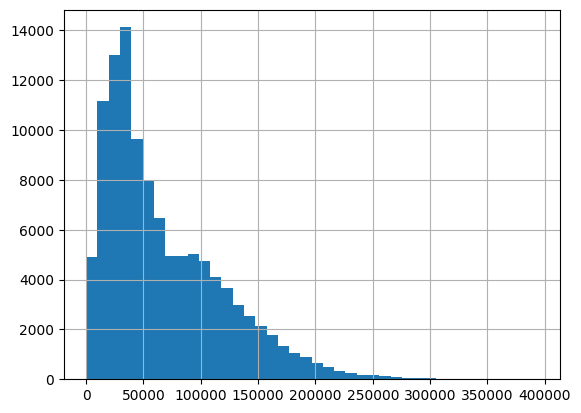

In [88]:
test_fill.query('odometer < 0.4e6')['odometer'].hist(bins=40);

In [89]:
#пропусков по одометру весьма мало, около 0,02%
#замена пропусков по одометру на медиану (хоть это идеологически не верно)
test_fill['odometer'] = test_fill['odometer'].fillna(test_fill['odometer'].median())

In [90]:
#самый ходовой цвет
train_fill.color_x.value_counts(normalize=True)[:5]

black     0.198851
white     0.190649
gray      0.149350
silver    0.149334
blue      0.091208
Name: color_x, dtype: float64

In [91]:
#замена
test_fill['color_x'] = test_fill['color_x'].fillna('black')

In [92]:
#самый ходовой interior
train_fill.interior_x.value_counts(normalize=True)[:5]

black    0.440153
gray     0.318900
beige    0.106396
tan      0.078567
—        0.030670
Name: interior_x, dtype: float64

In [93]:
#замена
test_fill['interior_x'] = test_fill['interior_x'].fillna('black')

In [94]:
#проверка результатов
test_fill.isna().sum()

year                 0
make                 0
model                0
trim_x               0
body_x               0
transmission_x       0
vin                  0
state                0
condition         2379
odometer             0
color_x              0
interior_x           0
seller               0
saledate             0
trim_y             596
body_y             596
transmission_y     596
color_y            596
interior_y         596
dtype: int64

In [95]:
#удаление 67 строк с авто у которых нет показаний одометра (только для трейна)
#removing 67 rows from cars that do not have odometer readings (only for train)

train_fill = train_fill.loc[~train_fill['odometer'].isna()]

In [96]:
train_fill.transmission_x.unique()

array(['automatic', 'manual'], dtype=object)

In [98]:
train_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432046 entries, 0 to 432112
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            432046 non-null  int64  
 1   make            432046 non-null  object 
 2   model           432046 non-null  object 
 3   trim_x          432046 non-null  object 
 4   body_x          432046 non-null  object 
 5   transmission_x  432046 non-null  object 
 6   vin             432046 non-null  object 
 7   state           432046 non-null  object 
 8   condition       422755 non-null  float64
 9   odometer        432046 non-null  float64
 10  color_x         432046 non-null  object 
 11  interior_x      432046 non-null  object 
 12  seller          432046 non-null  object 
 13  sellingprice    432046 non-null  int64  
 14  saledate        432046 non-null  object 
 15  trim_y          432046 non-null  object 
 16  body_y          432046 non-null  object 
 17  transmissi

In [99]:
train_fill.saledate[0]

'Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)'

In [100]:
train_fill.saledate[0][11:15]

'2015'

In [101]:
#for replace 'saledate'
def change_date(val):
    return val[11:15]

In [102]:
#замена даты продажи на год продажи
#replacing the date of sale with the year of sale

train_fill.saledate = train_fill.saledate.apply(change_date)

In [103]:
#for test
test_fill.saledate = test_fill.saledate.apply(change_date)

In [104]:
#замена на int32
#replace with int32

train_fill.saledate = train_fill.saledate.astype('Int32')

In [105]:
#also for test

test_fill.saledate = test_fill.saledate.astype('Int32')

In [106]:
#удаление всех столбцов с припиской в названии '_y'
#delete all columns c '_y'

train_fill = train_fill.drop(col_for_fill+'_y', axis=1)

In [107]:
test_fill = test_fill.drop(col_for_fill+'_y', axis=1)

In [108]:
#добавление времени между выпуском авто и продажей
#сразу с модулем так как есть часть дат с "минус 1" годом

#adding time between car release and sale
#immediately with the module since there are some dates with “minus 1” year

train_fill['life_car'] = (train_fill['saledate']  - train_fill['year']).abs()
train_fill.sample(2)

,year,make,model,trim_x,body_x,transmission_x,vin,state,condition,odometer,color_x,interior_x,seller,sellingprice,saledate,life_car
371533,2013,ford,fusion,se,sedan,automatic,3fa6p0hr7dr226251,mi,3.8,26791.0,gray,black,"ford motor credit company,llc",14700,2014,1
309747,2010,mazda,mazda3,i touring,sedan,manual,jm1bl1sg6a1179284,va,2.7,77259.0,white,black,mazda and volkswagon of fredericksburg,6400,2015,5


In [109]:
test_fill['life_car'] = (test_fill['saledate']  - test_fill['year']).abs()
test_fill.sample(2)

,year,make,model,trim_x,body_x,transmission_x,vin,state,condition,odometer,color_x,interior_x,seller,saledate,life_car
15468,2009,chevrolet,suburban,1500 ls,suv,automatic,1gnfk163x9r113403,ut,1.0,426418.0,white,black,united leasing inc,2015,6
18286,2012,nissan,altima,2.5 s,sedan,automatic,1n4al2ap9cn428133,tx,4.1,63143.0,black,gray,nissan-infiniti lt,2015,3


In [110]:
#замена срока жизни машины с 0 на 1 год
#replace life_car from 0 to 1 year
train_fill.loc[train_fill['life_car'] == 0, 'life_car'] = 1
test_fill.loc[test_fill['life_car'] == 0, 'life_car'] = 1

In [111]:
#проверка что не осталось нулей
train_fill.loc[train_fill['life_car'] == 0]

,year,make,model,trim_x,body_x,transmission_x,vin,state,condition,odometer,color_x,interior_x,seller,sellingprice,saledate,life_car


In [112]:
test_fill.loc[test_fill['life_car'] == 0]

,year,make,model,trim_x,body_x,transmission_x,vin,state,condition,odometer,color_x,interior_x,seller,saledate,life_car


In [113]:
#расчёт среднегодового пробега
#calculation of average annual mileage

train_fill['mean_go'] = train_fill['odometer'] / train_fill['life_car']
train_fill['mean_go'] = train_fill['mean_go'].astype('float')
train_fill.sample(2)

,year,make,model,trim_x,body_x,transmission_x,vin,state,condition,odometer,color_x,interior_x,seller,sellingprice,saledate,life_car,mean_go
147398,2010,toyota,camry,le,sedan,automatic,4t1bf3ek6au024960,fl,3.3,99092.0,silver,gray,"jpmorgan chase bank,n.a.",8000,2015,5,19818.400000
104308,2012,toyota,tacoma,prerunner v6,double cab,automatic,3tmju4gn8cm132717,ca,5.0,82333.0,white,gray,mountain motors inc,20750,2015,3,27444.333333


In [114]:
test_fill['mean_go'] = test_fill['odometer'] / test_fill['life_car']
test_fill['mean_go'] = test_fill['mean_go'].astype('float')
test_fill.sample(2)

,year,make,model,trim_x,body_x,transmission_x,vin,state,condition,odometer,color_x,interior_x,seller,saledate,life_car,mean_go
57838,2013,bmw,x3,xdrive28i,suv,automatic,5uxwx9c57d0a23851,pa,2.6,46742.0,white,beige,j magnone auto group llc,2015,2,23371.000000
38480,2009,pontiac,g3,base,hatchback,automatic,kl2td66e19b667641,pa,1.9,65545.0,red,black,"wheels of fortune auto, inc",2015,6,10924.166667


In [115]:
train_fill.isna().sum()

year                 0
make                 0
model                0
trim_x               0
body_x               0
transmission_x       0
vin                  0
state                0
condition         9291
odometer             0
color_x              0
interior_x           0
seller               0
sellingprice         0
saledate             0
life_car             0
mean_go              0
dtype: int64

In [116]:
test_fill.isna().sum()

year                 0
make                 0
model                0
trim_x               0
body_x               0
transmission_x       0
vin                  0
state                0
condition         2379
odometer             0
color_x              0
interior_x           0
seller               0
saledate             0
life_car             0
mean_go              0
dtype: int64

In [117]:
train_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432046 entries, 0 to 432112
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            432046 non-null  int64  
 1   make            432046 non-null  object 
 2   model           432046 non-null  object 
 3   trim_x          432046 non-null  object 
 4   body_x          432046 non-null  object 
 5   transmission_x  432046 non-null  object 
 6   vin             432046 non-null  object 
 7   state           432046 non-null  object 
 8   condition       422755 non-null  float64
 9   odometer        432046 non-null  float64
 10  color_x         432046 non-null  object 
 11  interior_x      432046 non-null  object 
 12  seller          432046 non-null  object 
 13  sellingprice    432046 non-null  int64  
 14  saledate        432046 non-null  Int32  
 15  life_car        432046 non-null  Int64  
 16  mean_go         432046 non-null  float64
dtypes: Int32(1

In [118]:
test_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110058 entries, 0 to 110057
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            110058 non-null  int64  
 1   make            110058 non-null  object 
 2   model           110058 non-null  object 
 3   trim_x          110058 non-null  object 
 4   body_x          110058 non-null  object 
 5   transmission_x  110058 non-null  object 
 6   vin             110058 non-null  object 
 7   state           110058 non-null  object 
 8   condition       107679 non-null  float64
 9   odometer        110058 non-null  float64
 10  color_x         110058 non-null  object 
 11  interior_x      110058 non-null  object 
 12  seller          110058 non-null  object 
 13  saledate        110058 non-null  Int32  
 14  life_car        110058 non-null  Int64  
 15  mean_go         110058 non-null  float64
dtypes: Int32(1), Int64(1), float64(3), int64(1), object(10)


In [119]:
train_fill.loc[train_fill['odometer'].isna()]

,year,make,model,trim_x,body_x,transmission_x,vin,state,condition,odometer,color_x,interior_x,seller,sellingprice,saledate,life_car,mean_go


In [120]:
#заполнение пробега. Медианное значение пробега умножить на срок жизни машины
# fill mileage. Median mileage multiplied by the life of the car

train_fill.loc[train_fill['odometer'].isna(), 'odometer'] = train_fill['life_car'] * train_fill['mean_go'].median()

In [121]:
train_fill.isna().sum()

year                 0
make                 0
model                0
trim_x               0
body_x               0
transmission_x       0
vin                  0
state                0
condition         9291
odometer             0
color_x              0
interior_x           0
seller               0
sellingprice         0
saledate             0
life_car             0
mean_go              0
dtype: int64

In [122]:
#check correlation 
train_fill[['condition', 'life_car', 'odometer']].corr()

,condition,life_car,odometer
condition,1.000000,-0.547665,-0.538087
life_car,-0.547665,1.000000,0.773951
odometer,-0.538087,0.773951,1.000000


Видна отрицательная связь между состоянием машины и возрастом  (корреляция -0,55) и так же обратная связь между состоянием машины и пробегом (корр -0,54).

На этом основании, можно обучить лин регрессию и таким образом заполнить пропущенные данные по состоянию машины `condition`.
-- --
There is a negative relationship between the condition of the car and age (correlation -0.55) and also an inverse relationship between the condition of the car and mileage (correlation -0.54).

On this basis, it is possible to train linear regression and thus fill in the missing data on the state of the machine `condition`.

#### LinearRegression

для заполнения пропусков по состоянию машины

to fill in gaps based on vehicle condition

In [123]:
train_for_condition = train_fill.loc[~train_fill['condition'].isna()][['condition', 'life_car', 'odometer']]
train_for_condition.sample(2)

,condition,life_car,odometer
283897,3.5,2,61533.0
24766,2.4,9,90487.0


In [124]:
params = {'fit_intercept':[True]}

In [125]:
lr = LinearRegression()

In [126]:
clf = GridSearchCV(lr, params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

In [127]:
%%time
clf.fit(train_for_condition[['life_car', 'odometer']], train_for_condition['condition'])

CPU times: user 165 ms, sys: 139 ms, total: 304 ms
Wall time: 2.51 s


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True]},
             scoring='neg_mean_squared_error')

In [128]:
clf.best_score_

-0.5987655963990213

In [129]:
#то есть RMSE
#that is RMSE

np.abs(clf.best_score_)**.5

0.773799454897082

In [130]:
%%time
lr.fit(train_for_condition[['life_car', 'odometer']], train_for_condition['condition'])

CPU times: user 67.7 ms, sys: 34.3 ms, total: 102 ms
Wall time: 68.5 ms


LinearRegression()

Использую обученную модель для заполнения пропусков в столбце `condition`
-- --
Using a trained model to fill in the gaps in the `condition` column

In [131]:
train_cond = train_fill.loc[train_fill['condition'].isna()][['life_car', 'odometer']]
train_cond.head(2)

,life_car,odometer
85,15,219516.0
117,7,127936.0


In [132]:
test_cond = test_fill.loc[test_fill['condition'].isna()][['life_car', 'odometer']]
test_cond.head(2)

,life_car,odometer
47,10,89590.0
72,14,76674.0


In [133]:
#предсказания на трейне
pred = lr.predict(train_cond)
pred

array([1.81399601, 2.9340768 , 2.32174844, ..., 3.29701967, 2.64321881,
       2.48405219])

In [134]:
#предсказания на тесте
pred_test = lr.predict(test_cond)
pred_test

array([2.8879348 , 2.62986083, 2.33524772, ..., 2.58120947, 3.62432301,
       2.7060215 ])

In [135]:
pred.min(), pred.max()

(-1.3893041476781178, 4.07890198818024)

In [136]:
pred_test.min(), pred_test.max()

(0.8932296869785237, 4.069139233539561)

In [137]:
train_fill['condition'].min(), train_fill['condition'].max()

(1.0, 5.0)

In [138]:
#замена всех значений меньше 1 на 1
pred = np.where(pred > 1, pred, 1)

In [139]:
pred_test = np.where(pred_test > 1, pred_test, 1)

In [140]:
pred.min(), pred.max()

(1.0, 4.07890198818024)

In [141]:
pred_test.min(), pred_test.max()

(1.0, 4.069139233539561)

In [142]:
#замена пропусков по condition на предсказанные значения
train_fill.loc[train_fill['condition'].isna(), 'condition'] = pred

In [143]:
test_fill.loc[test_fill['condition'].isna(), 'condition'] = pred_test

In [144]:
#проверка одного значения
#check one values

train_fill.loc[432100]

year                              2000
make                              audi
model                               a4
trim_x                    1.8t quattro
body_x                           sedan
transmission_x               automatic
vin                  waudc28dxya073343
state                               mo
condition                     2.484052
odometer                      105021.0
color_x                            red
interior_x                           —
seller            o'fallon motorsports
sellingprice                      2500
saledate                          2014
life_car                            14
mean_go                         7501.5
Name: 432100, dtype: object

In [145]:
train_fill.isna().sum()

year              0
make              0
model             0
trim_x            0
body_x            0
transmission_x    0
vin               0
state             0
condition         0
odometer          0
color_x           0
interior_x        0
seller            0
sellingprice      0
saledate          0
life_car          0
mean_go           0
dtype: int64

In [146]:
test_fill.isna().sum()

year              0
make              0
model             0
trim_x            0
body_x            0
transmission_x    0
vin               0
state             0
condition         0
odometer          0
color_x           0
interior_x        0
seller            0
saledate          0
life_car          0
mean_go           0
dtype: int64

###### Все, пропусков нет
-- --
##### That's it, no passes

In [147]:
train_fill['mean_go'].max()

999999.0

## 3. подготовка датасета train_fill для обучения
## 3. preparing the train_fill dataset for training

In [148]:
train_fill.sample(2)

,year,make,model,trim_x,body_x,transmission_x,vin,state,condition,odometer,color_x,interior_x,seller,sellingprice,saledate,life_car,mean_go
250172,2012,honda,accord,se,sedan,automatic,1hgcp2f6xca229687,il,3.7,64352.0,black,black,"ahfc/honda lease trust/hvt, inc. eot",11700,2015,3,21450.666667
251726,2014,ford,edge,limited,suv,automatic,2fmdk3kc6eba39164,tx,3.7,34090.0,red,—,avis corporation,21500,2015,1,34090.000000


In [149]:
#удаление лишних столбцов
#remove unnecessary columns

col_del = ['year','vin', 'seller', 'saledate']
train_fit = train_fill.drop(col_del, axis=1)
train_fit.sample(2)

,make,model,trim_x,body_x,transmission_x,state,condition,odometer,color_x,interior_x,sellingprice,life_car,mean_go
33719,ford,escape,se,suv,automatic,mn,4.2,46191.0,white,black,17900,1,46191.0
243676,saturn,outlook,xe,suv,automatic,tx,2.6,182840.0,silver,gray,4600,8,22855.0


In [150]:
ohe = OneHotEncoder(handle_unknown='ignore')

In [151]:
train_fit.columns

Index(['make', 'model', 'trim_x', 'body_x', 'transmission_x', 'state',
       'condition', 'odometer', 'color_x', 'interior_x', 'sellingprice',
       'life_car', 'mean_go'],
      dtype='object')

In [152]:
#список категориальных столбцов
train_fit_cat_col = ['make', 'model', 'trim_x', 'body_x', 'transmission_x', 'state',
       #'condition', 'odometer',
                 'color_x', 'interior_x',
                 #'sellingprice', 'life_car', 'mean_go'
                 ]

In [153]:
#список числовых столбцов
train_fit_num_col = [#'make', 'model', 'trim_x', 'body_x', 'transmission_x', 'state',
       'condition', 'odometer',
                 #'color_x', 'interior_x',
                 #'sellingprice',
                     'life_car', 'mean_go'
                 ]

In [154]:
#преобразование категор столбцов техникой OHE
#converting column categories using OHE technique

train_fit_ohe = ohe.fit_transform(train_fit[train_fit_cat_col])
train_fit_ohe

<432046x2854 sparse matrix of type '<class 'numpy.float64'>'
	with 3456368 stored elements in Compressed Sparse Row format>

In [155]:
#приведение числовых столбцов одному типу
#casting numeric columns to the same type

train_fit[train_fit_num_col] = train_fit[train_fit_num_col].astype('float64')

In [156]:
#преобразование нум столбцов в sparse matrix
#convert num columns to sparse matrix

train_fit_num = csr_matrix(train_fit[train_fit_num_col])

In [157]:
#проверка линейной корреляции Пирсона между числовыми столцами
#check linear correlation of Pirson

train_fit[train_fit_num_col].corr()

,condition,odometer,life_car,mean_go
condition,1.000000,-0.546067,-0.555865,-0.003063
odometer,-0.546067,1.000000,0.773951,0.202893
life_car,-0.555865,0.773951,1.000000,-0.276042
mean_go,-0.003063,0.202893,-0.276042,1.000000


Есть приличная корреляция между сроком жизни машины и показаниями одометра, что совпадает со здравым смыслом.

Пока этот коррелирующий столбец удалять не буду.
-- --
There is a decent correlation between the life of a car and the odometer reading, which is common sense.

I will not delete this correlating column for now.

In [158]:
#соединение двух sparse matrix в одну
#join two sparse matrix in one

train_fit_sparse = hstack((train_fit_ohe, train_fit_num))
train_fit_sparse

<432046x2858 sparse matrix of type '<class 'numpy.float64'>'
	with 5184552 stored elements in Compressed Sparse Row format>

## 4. кластеризация (проба)
## 4. clustering (trial)

In [159]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [160]:
#выборка 1/10 части датасета (для ускорения расчётов)
#sampling 1/10 of the dataset (to speed up calculations)

train_sample = train_fit.sample(frac=0.1, replace=True, random_state=STATE).reset_index(drop=True)
train_sample.head(2)

,make,model,trim_x,body_x,transmission_x,state,condition,odometer,color_x,interior_x,sellingprice,life_car,mean_go
0,nissan,altima,2.5 s,sedan,automatic,ca,2.4,45157.0,black,black,10100,3.0,15052.333333
1,audi,a3,1.8 tfsi premium,sedan,automatic,ca,5.0,10507.0,white,black,25250,1.0,10507.000000


In [161]:
train_sample.shape

(43205, 13)

In [162]:
#масштабирование числ признаков
train_sample[train_fit_num_col] = StandardScaler().fit_transform(train_sample[train_fit_num_col])
train_sample.head(2)

,make,model,trim_x,body_x,transmission_x,state,condition,odometer,color_x,interior_x,sellingprice,life_car,mean_go
0,nissan,altima,2.5 s,sedan,automatic,ca,-1.087017,-0.424075,black,black,10100,-0.470488,-0.111429
1,audi,a3,1.8 tfsi premium,sedan,automatic,ca,1.667179,-1.086018,white,black,25250,-0.989277,-0.611191


In [163]:
encoder = OrdinalEncoder()

In [164]:
train_sample_oe =  pd.DataFrame(encoder.fit_transform(train_sample[train_fit_cat_col]), columns=train_fit_cat_col)
train_sample_oe.head(3)

,make,model,trim_x,body_x,transmission_x,state,color_x,interior_x
0,34.0,52.0,77.0,31.0,0.0,3.0,1.0,1.0
1,2.0,36.0,16.0,31.0,0.0,3.0,17.0,1.0
2,13.0,242.0,841.0,31.0,0.0,3.0,17.0,1.0


In [165]:
train_sample_oe = train_sample_oe.join(train_sample[train_fit_num_col]).join(train_sample['sellingprice'])
train_sample_oe.head(3)

,make,model,trim_x,body_x,transmission_x,state,color_x,interior_x,condition,odometer,life_car,mean_go,sellingprice
0,34.0,52.0,77.0,31.0,0.0,3.0,1.0,1.0,-1.087017,-0.424075,-0.470488,-0.111429,10100
1,2.0,36.0,16.0,31.0,0.0,3.0,17.0,1.0,1.667179,-1.086018,-0.989277,-0.611191,25250
2,13.0,242.0,841.0,31.0,0.0,3.0,17.0,1.0,0.925664,-0.529642,-0.729883,0.412283,11600


In [166]:
#вычисление DBSCAN
#DBSCAN calculation

db = DBSCAN(eps=0.3, min_samples=12).fit(train_sample[train_fit_num_col])

In [167]:
labels = db.labels_
labels = pd.Series(labels)
labels.value_counts()

 0     41260
-1      1616
 1        84
 2        39
 5        39
 7        37
 6        23
 4        21
 8        14
 13       14
 12       14
 3        12
 9        12
 11       11
 10        9
dtype: int64

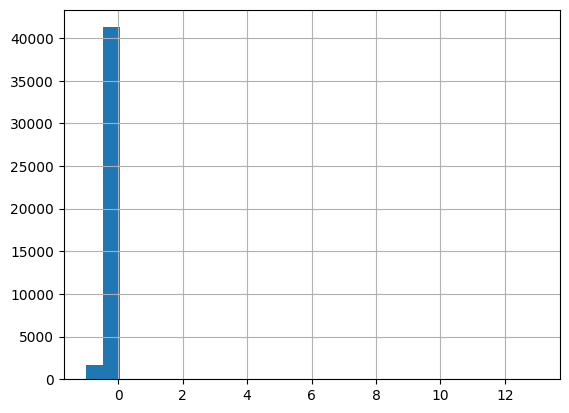

In [168]:
labels.hist(bins=27);

In [169]:
train_sample['dbscan'] = labels
train_sample.head(5)

,make,model,trim_x,body_x,transmission_x,state,condition,odometer,color_x,interior_x,sellingprice,life_car,mean_go,dbscan
0,nissan,altima,2.5 s,sedan,automatic,ca,-1.087017,-0.424075,black,black,10100,-0.470488,-0.111429,0
1,audi,a3,1.8 tfsi premium,sedan,automatic,ca,1.667179,-1.086018,white,black,25250,-0.989277,-0.611191,0
2,ford,focus,se,sedan,automatic,ca,0.925664,-0.529642,white,black,11600,-0.729883,0.412283,0
3,infiniti,g sedan,g37x,g sedan,automatic,il,0.607872,-0.919415,gray,gray,22200,-0.729883,-0.709376,0
4,chevrolet,impala,lt fleet,sedan,automatic,mo,-0.663295,0.107525,silver,gray,7300,-0.470488,0.908434,0


In [170]:
train_fit_num_col

['condition', 'odometer', 'life_car', 'mean_go']

In [171]:
#вычисление линейной корреляции
train_sample[['condition', 'odometer', 'life_car', 'mean_go', 'dbscan']].corr()

,condition,odometer,life_car,mean_go,dbscan
condition,1.000000,-0.557302,-0.557570,-0.004791,-0.076238
odometer,-0.557302,1.000000,0.783112,0.184336,-0.051066
life_car,-0.557570,0.783112,1.000000,-0.284687,-0.016534
mean_go,-0.004791,0.184336,-0.284687,1.000000,-0.059676
dbscan,-0.076238,-0.051066,-0.016534,-0.059676,1.000000


не видно линейной корреляции между числовыми признаками и dbscan

no linear correlation is visible between numerical features and dbscan

#### проверка эффекта от кластеризации для одной модели (случайный лес)

#### checking the effect of clustering for one model (random forest)

In [172]:
features_dbscan = train_sample[['condition', 'odometer', 'life_car', 'mean_go', 'dbscan']]
features = train_sample[train_fit_num_col]
target = train_sample['sellingprice']

In [173]:
features_dbscan.shape, features.shape, target.shape

((43205, 5), (43205, 4), (43205,))

In [174]:
#логарифмическая сетка параметров
params = {
    'max_depth':[128],
    'n_estimators':[40],
    'min_samples_leaf':[4],
    'min_samples_split':[2]

}

In [175]:
rf_regr = RandomForestRegressor(random_state=STATE)

In [176]:
clf = GridSearchCV(rf_regr, params, scoring='neg_mean_absolute_percentage_error', cv=3, n_jobs=-1)

In [177]:
%%time
clf.fit(features_dbscan, target)

CPU times: user 6.71 s, sys: 27.1 ms, total: 6.74 s
Wall time: 15.9 s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=33443),
             n_jobs=-1,
             param_grid={'max_depth': [128], 'min_samples_leaf': [4],
                         'min_samples_split': [2], 'n_estimators': [40]},
             scoring='neg_mean_absolute_percentage_error')

In [178]:
round(-clf.best_score_, 4)

0.4896

##### та же модель но без dbscan

##### same model but without dbscan

In [179]:
%%time
clf.fit(features, target)

CPU times: user 6.64 s, sys: 26 ms, total: 6.66 s
Wall time: 15.2 s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=33443),
             n_jobs=-1,
             param_grid={'max_depth': [128], 'min_samples_leaf': [4],
                         'min_samples_split': [2], 'n_estimators': [40]},
             scoring='neg_mean_absolute_percentage_error')

In [180]:
round(-clf.best_score_, 4)

0.4897

на даный момент эффект от кластеризации есть, но крайне маленький, разница только в 4-м знаке
-- --
at the moment there is an effect from clustering, but it is extremely small, the difference is only in the 4th digit

#### Проверка эффекта от dbscan на всех столбцах кодированных Ordinal Encoder
-- --
#### Checking the effect of dbscan on all columns encoded by Ordinal Encoder

In [181]:
train_sample_oe.head(1)

,make,model,trim_x,body_x,transmission_x,state,color_x,interior_x,condition,odometer,life_car,mean_go,sellingprice
0,34.0,52.0,77.0,31.0,0.0,3.0,1.0,1.0,-1.087017,-0.424075,-0.470488,-0.111429,10100


In [182]:
#вычисление DBSCAN
#calculation DBSCAN
db = DBSCAN(eps=0.9, min_samples=12).fit(train_sample_oe.drop('sellingprice', axis=1))

In [183]:
labels = db.labels_
labels = pd.Series(labels)
labels.value_counts()

-1    43086
 0       19
 2       19
 3       16
 4       15
 1       14
 5       12
 7       12
 6       12
dtype: int64

In [184]:
train_sample_oe['dbscan'] = labels
train_sample_oe.head(2)

,make,model,trim_x,body_x,transmission_x,state,color_x,interior_x,condition,odometer,life_car,mean_go,sellingprice,dbscan
0,34.0,52.0,77.0,31.0,0.0,3.0,1.0,1.0,-1.087017,-0.424075,-0.470488,-0.111429,10100,-1
1,2.0,36.0,16.0,31.0,0.0,3.0,17.0,1.0,1.667179,-1.086018,-0.989277,-0.611191,25250,-1


In [185]:
features_oe_dbscan = train_sample_oe.drop('sellingprice', axis=1)
features_oe = train_sample_oe.drop(['sellingprice', 'dbscan'], axis=1)
target_oe = train_sample_oe['sellingprice']

In [186]:
features_oe_dbscan.shape, features_oe.shape, target_oe.shape

((43205, 13), (43205, 12), (43205,))

In [187]:
rf_regr = RandomForestRegressor(random_state=STATE)
clf = GridSearchCV(rf_regr, params, scoring='neg_mean_absolute_percentage_error', cv=3, n_jobs=-1)

In [188]:
%%time
clf.fit(features_oe_dbscan, target_oe)

CPU times: user 11.3 s, sys: 58 ms, total: 11.4 s
Wall time: 28.7 s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=33443),
             n_jobs=-1,
             param_grid={'max_depth': [128], 'min_samples_leaf': [4],
                         'min_samples_split': [2], 'n_estimators': [40]},
             scoring='neg_mean_absolute_percentage_error')

In [189]:
round(-clf.best_score_, 4)

0.2731

In [190]:
rf_regr = RandomForestRegressor(random_state=STATE)
clf = GridSearchCV(rf_regr, params, scoring='neg_mean_absolute_percentage_error', cv=3, n_jobs=-1)

In [191]:
%%time
clf.fit(features_oe, target_oe)

CPU times: user 10.3 s, sys: 68.7 ms, total: 10.3 s
Wall time: 27.1 s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=33443),
             n_jobs=-1,
             param_grid={'max_depth': [128], 'min_samples_leaf': [4],
                         'min_samples_split': [2], 'n_estimators': [40]},
             scoring='neg_mean_absolute_percentage_error')

In [192]:
round(-clf.best_score_, 4)

0.2731

В обоих случаях кластеризация не дала выигрыша по метрике!

Поэтому принимаю решение не делать её для основного датасета.
-- --
In both cases, clustering did not yield any gains in terms of the metric!

Therefore, I decide not to do it for the main dataset.

## 5. подготовка датасета test_fill для предсказания
## 5. preparing the test_fill dataset for prediction

In [193]:
test_fill.head(2)

,year,make,model,trim_x,body_x,transmission_x,vin,state,condition,odometer,color_x,interior_x,seller,saledate,life_car,mean_go
0,2005,cadillac,cts,base,sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,2015,10,11697.0
1,2014,gmc,savana cargo,2500,van,automatic,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,2015,1,6286.0


In [194]:
#удаление лишних столбцов
#col_del = ['year','vin', 'seller', 'saledate']
test_pr = test_fill.drop(col_del, axis=1)
test_pr.sample(2)

,make,model,trim_x,body_x,transmission_x,state,condition,odometer,color_x,interior_x,life_car,mean_go
103031,honda,pilot,ex-l w/rear entertainment,suv,automatic,pa,4.0,24582.0,black,gray,2,12291.0
5139,bmw,3 series,335i xdrive,sedan,manual,ca,3.9,23810.0,white,black,4,5952.5


In [195]:
#преобразование категор столбцов техникой OHE
test_pr_ohe = ohe.transform(test_pr[train_fit_cat_col])
test_pr_ohe

<110058x2854 sparse matrix of type '<class 'numpy.float64'>'
	with 880164 stored elements in Compressed Sparse Row format>

In [196]:
#приведение числовых столбцов одному типу
test_pr[train_fit_num_col] = test_pr[train_fit_num_col].astype('float64')

In [197]:
#преобразование нум столбцов в sparse matrix
test_pr_num = csr_matrix(test_pr[train_fit_num_col])

In [198]:
#соединение двух sparse matrix в одну
test_pr_sparse = hstack((test_pr_ohe, test_pr_num))
test_pr_sparse

<110058x2858 sparse matrix of type '<class 'numpy.float64'>'
	with 1320396 stored elements in Compressed Sparse Row format>

In [199]:
#проверка на отсутствие nan
np.isnan(test_pr_sparse.data).any()

False

## 6. Модели
## 6. Models

### 6.1. Линейная регрессия
### 6.1. Linear Regression

In [200]:
np.isnan(train_fit_ohe.data).any()

False

In [201]:
np.isnan(train_fit_num.data).any()

False

In [202]:
np.isnan(train_fit_sparse.data).any()

False

In [203]:
train_fit[train_fit_num_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432046 entries, 0 to 432112
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   condition  432046 non-null  float64
 1   odometer   432046 non-null  float64
 2   life_car   432046 non-null  float64
 3   mean_go    432046 non-null  float64
dtypes: float64(4)
memory usage: 32.6 MB


In [204]:
#обучение модели
params = {#'alpha':[0.2],
          'fit_intercept':[True]
          }

#lr = linear_model.Lasso()
lr = LinearRegression()
clf = GridSearchCV(lr, params, scoring='neg_mean_absolute_percentage_error', cv=5, n_jobs=-1)

In [205]:
#n = 20000
n = train_fit_ohe.shape[0]
n

432046

In [206]:
%%time
clf.fit(train_fit_sparse[:n], train_fit['sellingprice'][:n])

CPU times: user 565 ms, sys: 367 ms, total: 931 ms
Wall time: 3.2 s


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True]},
             scoring='neg_mean_absolute_percentage_error')

In [207]:
-clf.best_score_

0.7428988884845719

In [208]:
clf.best_params_

{'fit_intercept': True}

In [209]:
0.7430577776062411

0.7430577776062411

In [210]:
#обучение заново
%%time
lr.fit(train_fit_sparse[:n], train_fit['sellingprice'][:n])

CPU times: user 467 ms, sys: 317 ms, total: 783 ms
Wall time: 514 ms


LinearRegression()

модель Lasso даёт лучше результат, МАРЕ примерно 0,54, но крайне долго обучается.

The Lasso model gives better results, MAPE is approximately 0.54, but takes an extremely long time to train.

#### Проверка точности на обучающей выборке
#### Checking accuracy on the training set

In [211]:
pred_train = lr.predict(train_fit_sparse[:n])

In [212]:
pred_train.min(), pred_train.max()

(-68932.90656265916, 39619.74574731784)

In [213]:
train_fit['sellingprice'][:n].min(), train_fit['sellingprice'][:n].max()

(1, 230000)

In [214]:
mean_absolute_percentage_error(train_fit['sellingprice'][:n], pred_train)

0.7424855343841174

На кросс валидации, при 3х фолдах, MAPE примерно 0,74%

MAPE is approximately 0.74

### 6.2. DecisionTreeRegressor


In [215]:
#логарифмическая сетка параметров для модели Дерево
params = {
    'max_depth':[128],
    'min_samples_leaf':[2,4],
    'min_samples_split':[2,4]

}

In [216]:
TreeReg = DecisionTreeRegressor(random_state=STATE)

In [217]:
clf = GridSearchCV(TreeReg, params, scoring='neg_mean_absolute_percentage_error', cv=3, n_jobs=-1)

In [218]:
%%time
#clf.fit(train_fit_sparse[:n], train_fit['sellingprice'][:n])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [219]:
#-clf.best_score_

#### Результаты для разных гиперпараметров

#### Results for different hyperparameters

0.3327144211074122 'max_depth':[16,

0.24617415713104904 {'max_depth': 32, 'min_samples_leaf': 4, 'min_samples_split': 2}

0.2272899503074534 {'max_depth': 64, 'min_samples_leaf': 4, 'min_samples_split': 2}

0.225817829323637 {'max_depth': 128, 'min_samples_leaf': 4, 'min_samples_split': 2}

0.225817829323637 {'max_depth': 128, 'min_samples_leaf': 4, 'min_samples_split': 2} (256 ничего не даёт)

In [221]:
#учим заново
%%time
TreeReg = DecisionTreeRegressor(random_state=STATE,
                                max_depth=128,
                                min_samples_leaf=4,
                                min_samples_split=2
                                )
TreeReg.fit(train_fit_sparse[:n], train_fit['sellingprice'][:n])

CPU times: user 3min, sys: 306 ms, total: 3min 1s
Wall time: 3min 4s


DecisionTreeRegressor(max_depth=128, min_samples_leaf=4, random_state=33443)

### 6.3. Random forest

In [222]:
#логарифмическая сетка параметров
params = {
    'max_depth':[64],
    'n_estimators':[20],
    'min_samples_leaf':[4],
    'min_samples_split':[2]

}

In [223]:
rf_regr = RandomForestRegressor(random_state=STATE)

In [224]:
clf = GridSearchCV(rf_regr, params, scoring='neg_mean_absolute_percentage_error', cv=3, n_jobs=-1)

In [225]:
%%time
#clf.fit(train_fit_sparse[:n], train_fit['sellingprice'][:n])

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


In [226]:
#round(-clf.best_score_, 4)

In [227]:
#clf.best_params_

#### Результаты для разных гипер_параметров

#### Results for different hyperparameters

0.4796 {'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 20}

0.2008 {'max_depth': 64,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 20} Wall time: 1h 43min 6s


In [228]:
#заново учим
rf_regr = RandomForestRegressor(random_state=STATE,
                                max_depth=64,
                                n_estimators=40,
                                min_samples_leaf=4,
                                min_samples_split=2
                                )

In [229]:
%%time
rf_regr.fit(train_fit_sparse[:n], train_fit['sellingprice'][:n])

CPU times: user 1h 20min 14s, sys: 6.31 s, total: 1h 20min 20s
Wall time: 1h 20min 46s


RandomForestRegressor(max_depth=64, min_samples_leaf=4, n_estimators=40,
                      random_state=33443)

## 7. Получение предсказаний на тестовой выборке
## 7. Getting predictions on a test sample

In [238]:
#предсказания на случайном лесе
#predictions on a random forest

pred_test = rf_regr.predict(test_pr_sparse[:n])

In [239]:
#min and max values of predictions
pred_test.min(), pred_test.max()

(336.924930971806, 155611.35776029524)

## 8. сборка выходного файла для платформы каггл
## 8. building the output file for the Kaggle platform

In [241]:
pred_test = pd.Series(pred_test)

In [242]:
pred_out = pd.concat([test['vin'], pred_test], axis=1)
pred_out

,vin,0
0,1g6dp567450124779,3681.893759
1,1gtw7fca7e1902207,22698.299531
2,jn8az1mw6dw303497,19065.675213
3,2g1wf5e34d1160703,8848.026651
4,1n6aa0ec3dn301209,21664.080943
...,...,...
110053,1j4aa2d17bl584330,17032.486004
110054,jthbf1d23e5007526,29996.007499
110055,1n4ba41e54c831950,3559.134029
110056,jn1az4eh3dm382431,16152.670590


In [243]:
pred_out.columns = ['vin', 'sellingprice']

In [244]:
pred_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           110058 non-null  object 
 1   sellingprice  110058 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.7+ MB


In [245]:
#сохранение результатов на диск
#saving results to disk

patch = os.path.join(DATA_PATH, 'pred_out.csv')
pd.DataFrame(pred_out).to_csv(patch, index=False)

## The result 
according to the Kaggle platform is:

Public Score - 18.01

Private Score - 18.14